In [1]:
import sys
sys.path.append('..')

import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from collections import defaultdict
from glob import glob
from sklearn.model_selection import train_test_split
from transformers import get_cosine_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
from os.path import join
import wandb
import torch.nn as nn
import yaml

from torch.multiprocessing import Pool, Process, set_start_method

from base_model import KnowledgeModel
from data_loading import prepare_data, CollateClass, make_dataloader

2023-05-14 22:57:29.694170: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Processing

In [2]:
data = pd.read_pickle('../data/python_submits.pkl')

In [3]:
data

,submit_index,problem_id,user_id,contest_id,classes_id,verdict,score,timestamp,year,month,name,name.1,academic_year,code
0,0,8924,55622,296235,295176,OK,1,2019-09-19 13:29:55,2019,9,M102-19/20,"Python_base_1,2-M102-19/20",19/20,a = int(input())\nb = a + 1\nprint(b)\n
1,1,8924,59912,296235,295176,OK,1,2019-09-19 13:30:38,2019,9,M102-19/20,"Python_base_1,2-M102-19/20",19/20,a = int(input())\nb = a + 1\nprint(b)
2,2,8924,49592,296235,295176,OK,1,2019-09-19 13:33:11,2019,9,M102-19/20,"Python_base_1,2-M102-19/20",19/20,a = int(input())\nb = a + 1\nprint(b)
3,3,8924,49151,296235,295176,OK,1,2019-09-19 13:33:54,2019,9,M102-19/20,"Python_base_1,2-M102-19/20",19/20,a = int(input())\nb = a + 1\nprint(b)\n
4,4,8924,52422,296235,295176,OK,1,2019-09-19 13:34:04,2019,9,M102-19/20,"Python_base_1,2-M102-19/20",19/20,a = int(input())\nb = a + 1\nprint(b)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700917,700917,446,168882,1002098,570456,PS,0,2022-11-09 13:49:02,2022,11,_M105-22/23,"Python_base_1,2-_M105-22/23",22/23,x = int(input())\ndec = x//10 %10\nhun = x//10...
700918,700918,446,168882,1002098,570456,PS,0,2022-11-09 13:49:25,2022,11,_M105-22/23,"Python_base_1,2-_M105-22/23",22/23,x = int(input())\ndec = x//10 %10\nhun = x//10...
700919,700919,446,168882,1002098,570456,PS,0,2022-11-09 13:49:57,2022,11,_M105-22/23,"Python_base_1,2-_M105-22/23",22/23,x = int(input())\ndec = x//10 %10\nhun = x//10...
700920,700920,202,160196,1002098,570456,PS,0,2022-11-09 14:19:25,2022,11,_M105-22/23,"Python_base_1,2-_M105-22/23",22/23,n=int(input())\na=n%10\nprint(a)


In [3]:
data.user_id.unique().shape

(3187,)

In [4]:
temp = pd.pivot_table(data, index='user_id',values='score',aggfunc='mean')

In [5]:
ranges = np.linspace(0,1,10)

user_ids = dict()

for i in range(len(ranges)-1):
    user_ids[i] = temp[temp.score.between(ranges[i],ranges[i+1])].index

In [6]:
config = yaml.safe_load(open("../config.yaml", "r"))
config['batch_size'] = 100

In [7]:
wandb.init(
    mode='disabled',
    config=config
)

problems = pd.read_pickle('../data/python_statements.pkl')
submits_embeddings = torch.load('../data/submits_emb.pt')
dataset = data.reset_index().set_index('user_id')
collate_fn = CollateClass('cpu', max_len=300)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [8]:
def get_embeddings(user_ids):
    dataloader = make_dataloader(user_ids, dataset, submits_embeddings, problems, shuffle=True,
                                        collate_fn=collate_fn)
    code_embs, prompt, scores = next(iter(dataloader))
    return code_embs

In [9]:
embeddings = []
for i in range(len(ranges)-1):
    embeddings.append(get_embeddings(user_ids[i]))

In [9]:
model = KnowledgeModel(1,3,256,8,128)
model.load_state_dict(torch.load('../model_state/model_checkpoint.pt'))
model.eval();

In [10]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [11]:
from utils import set_random_seed
set_random_seed(42)

In [15]:
to_del =[]
for i in tqdm(range(len(embeddings))):
    with torch.no_grad():
        embeddings[i] = model.decode(embeddings[i], 
                                    embeddings[i], 
                                    generate_square_subsequent_mask(embeddings[i].shape[0]))[-1]

100%|██████████| 9/9 [00:19<00:00,  2.17s/it]


In [16]:
lens = np.cumsum([len(i) for i in embeddings])

In [17]:
concat_emb = torch.cat(embeddings, axis=0)

## Data Visualizing

In [18]:
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
fit = UMAP()
u = fit.fit_transform(concat_emb.detach().numpy())

In [20]:
n_colors = len(lens)
colors = np.zeros((n_colors, 3))

# create the gradation of colors from red to green
for i in range(n_colors):
    colors[i, 0] = i / (n_colors - 1) # red component
    colors[i, 1] = 1 - i / (n_colors - 1) # green component

In [28]:
colors = colors[::-1]

100%|██████████| 8/8 [00:00<00:00, 99.56it/s]


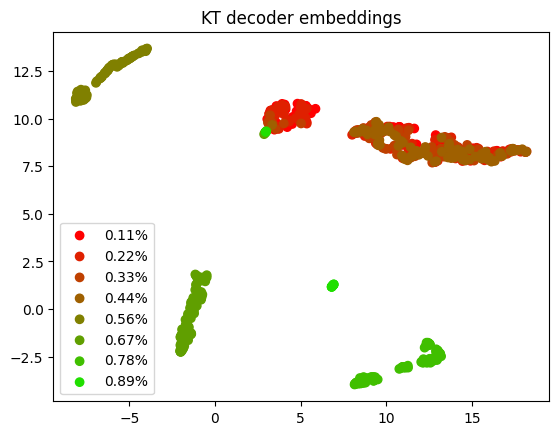

In [35]:
for i in tqdm(range(len(lens)-1)):
    plt.scatter(u[lens[i]:lens[i+1],0], u[lens[i]:lens[i+1],1], color=[colors[i]] * (lens[i+1]-lens[i]), label=f'{ranges[i+1]:.2f}%')
plt.legend()
plt.title('KT decoder embeddings')
plt.savefig('picture.png', facecolor='white')

In [ ]:
dataloader = make_dataloader(user_ids[4], dataset, submits_embeddings, problems, shuffle=False,
                                        collate_fn=collate_fn)
code_embs, prompt, scores = next(iter(dataloader))

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

num_heads = 8
num_layers = 3
d_model = 256
d_head = d_model//num_heads


def compute_selfattention(transformer_encoder,x,mask,src_key_padding_mask,i_layer,d_model,num_heads):
    h = F.linear(x, transformer_encoder.layers[i_layer].self_attn.in_proj_weight, bias=transformer_encoder.layers[i_layer].self_attn.in_proj_bias)
    qkv = h.reshape(x.shape[0], x.shape[1], num_heads, 3 * d_model//num_heads)
    qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
    q, k, v = qkv.chunk(3, dim=-1) # [Batch, Head, SeqLen, d_head=d_model//num_heads]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [Batch, Head, SeqLen, SeqLen]
    d_k = q.size()[-1]
    attn_probs = attn_logits / math.sqrt(d_k)
    # combining src_mask e.g. upper triangular with src_key_padding_mask e.g. columns over each padding position
    combined_mask = torch.zeros_like(attn_probs)
    if mask is not None:
        combined_mask += mask.float() # assume mask of shape (seq_len,seq_len)
    if src_key_padding_mask is not None:
        combined_mask += src_key_padding_mask.float().unsqueeze(1).unsqueeze(1).repeat(1,num_heads,x.shape[1],1)
        # assume shape (batch_size,seq_len), repeating along head and line dimensions == "column" mask
    combined_mask = torch.where(combined_mask>0,torch.zeros_like(combined_mask)-float("inf"),torch.zeros_like(combined_mask))
    # setting masked logits to -inf before softmax
    attn_probs += combined_mask
    attn_probs = F.softmax(attn_probs, dim=-1)
    return attn_logits,attn_probs

def extract_selfattention_maps(transformer_encoder,x,mask,src_key_padding_mask):
    attn_logits_maps = []
    attn_probs_maps = []
    num_layers = transformer_encoder.num_layers
    d_model = transformer_encoder.layers[0].self_attn.embed_dim
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            # attn = transformer_encoder.layers[i].self_attn(h, h, h,attn_mask=mask,key_padding_mask=src_key_padding_mask,need_weights=True)[1]
            # attention_maps.append(attn) # of shape [batch_size,seq_len,seq_len]
            attn_logits,attn_probs = compute_selfattention(transformer_encoder,h,mask,src_key_padding_mask,i,d_model,num_heads)
            attn_logits_maps.append(attn_logits) # of shape [batch_size,num_heads,seq_len,seq_len]
            attn_probs_maps.append(attn_probs)
            # forward of layer i
            x = transformer_encoder.layers[i](x, x)
    return attn_logits_maps,attn_probs_maps

In [14]:
attn_logits_maps,attn_probs_maps  = extract_selfattention_maps(model.transformer.decoder, 
                           code_embs.permute(1,0,2), 
                           generate_square_subsequent_mask(code_embs.shape[0]),
                           None)

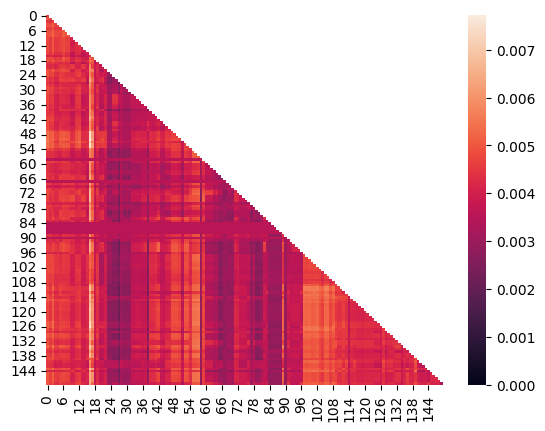

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap((attn_probs_maps[0][0][0]+generate_square_subsequent_mask(code_embs.shape[0]))[:150,:150].detach().numpy(), vmin=0)
plt.savefig('../figures/attention_layer_2.png', facecolor='white')

In [16]:
problems = pd.read_csv('../../data/problems.csv').set_index('id')

/tmp/ipykernel_15397/3322778042.py:1: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  problems = pd.read_csv('../../data/problems.csv').set_index('id')


In [23]:
print(problems.loc[441].statement)
print(problems.loc[441].statement_input)
print(problems.loc[441].statement_output)

Требуется написать программу, которая определяет цифры исходного четырёхзначного числа $x$ и выводит их на экран.
Входной поток содержит целое число $x$ ${(1000 \leqslant x \leqslant 9999)}$.
Выведите цифры числа $x$ по одной в строке, в следующем порядке: тысячи, сотни, десятки и затем единицы.


In [29]:
print(problems.loc[11154].statement)
print(problems.loc[11154].statement_input)
print(problems.loc[11154].statement_output)

<p>Фёдор любит откладывать дела на потом. Но каждый день мама просит его писать отчёт о том, как продвигается&nbsp;важное дело, которое она ему поручила сделать на неделе.</p>

<p>Первые N дней Фёдор откладывал дело на завтра. Потом он его выполнил. В оставшиеся дни он писал в ежедневном отчёте фразу &quot;Давно готово&quot;.</p>

<p>Выведите записи из отчёта Фёдора за неделю.</p>
<p>Целое число <strong>N</strong>: от 1 до 6.</p>
<p>Выведите на экран:</p>

<p>N строк с фразой &quot;Сделаю завтра&quot;.</p>

<p>Затем одна строка &quot;Выполнил важное дело&quot;.</p>

<p>В оставшиеся дни недели фраза &quot;Давно готово&quot;.</p>


В данном примере мы видим 2 задачи - решение первой задачи с первого раза оказало сильное влияние на следующий рост ученика, решение же второй задачи оказало слабое влияние. 